In [31]:
%load_ext autoreload
%autoreload 2

import numpy as np
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import random, time

from torch.utils.tensorboard import SummaryWriter

from datasets import synthetic as load_datasets
from datasets import real as load_real_datasets
from datasets import real_only as load_only_real_datasets
from utils import plotter, visualizer

import metrics
from models import PVT, UNet, ViT

import trainer as train_funct
from trainer import Trainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
writer = SummaryWriter()

In [3]:
train_funct.set_seed(42)

## Dataset

In [4]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [5]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [6]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 24005
Validation: 4000
Test: 4000


In [7]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [8]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


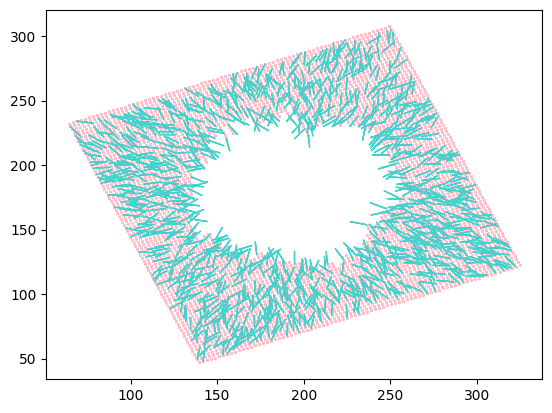

In [9]:
plotter.plot_train_data(train_data)

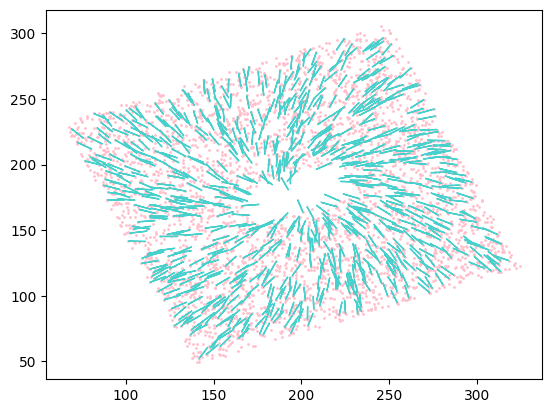

In [10]:
plotter.plot_data(val_data)

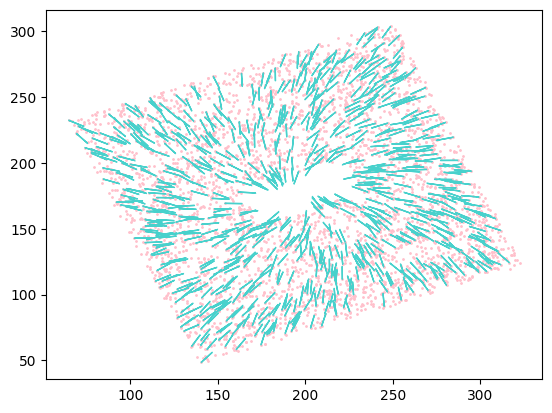

In [11]:
plotter.plot_data(test_data)

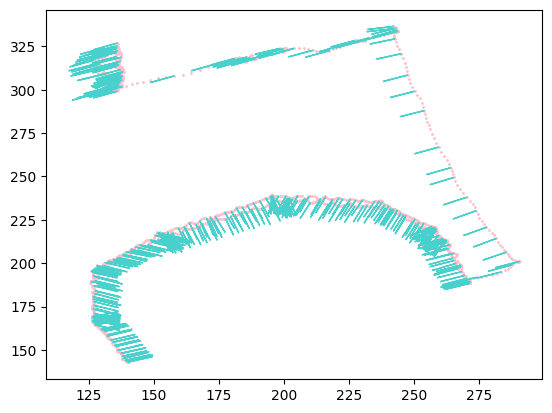

In [12]:
plotter.plot_data(real_data)

In [13]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Validation before filtering: 4000


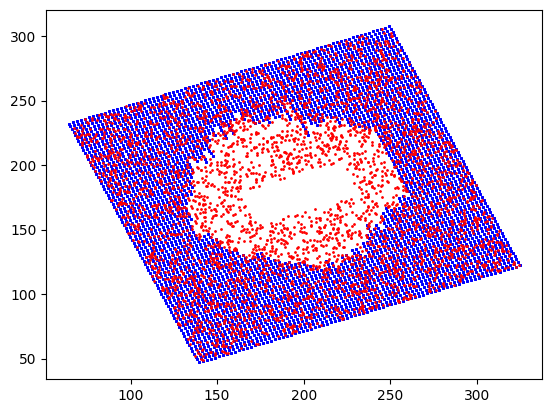

In [14]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2066.32it/s]


Validation after filtering: 3253


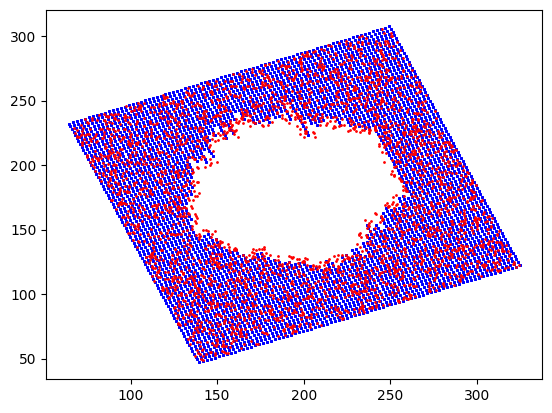

In [15]:
visualizer.filter_data(train_data, val_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


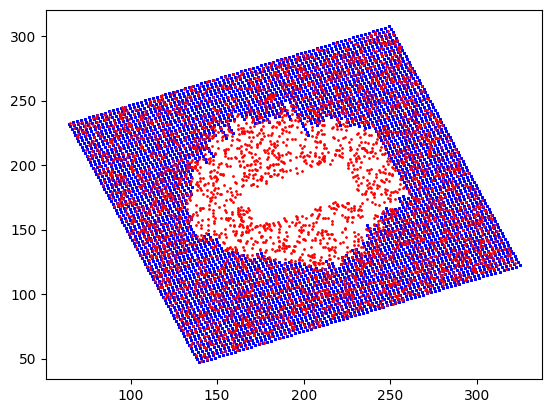

In [16]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2078.74it/s]


Test after filtering: 3271


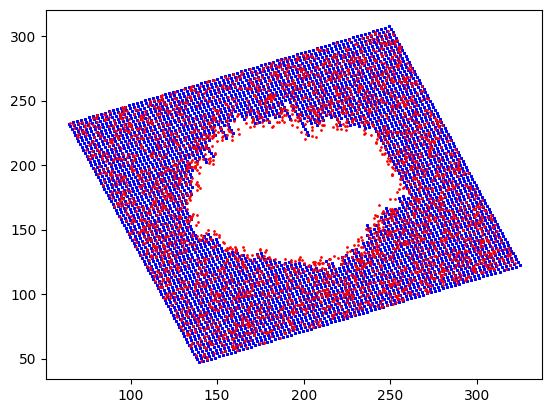

In [17]:
visualizer.filter_data(train_data, test_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

iou: 0.9185888716281714
yaw difference tensor(7.2461) deg
localization error:  0.037775546 meters


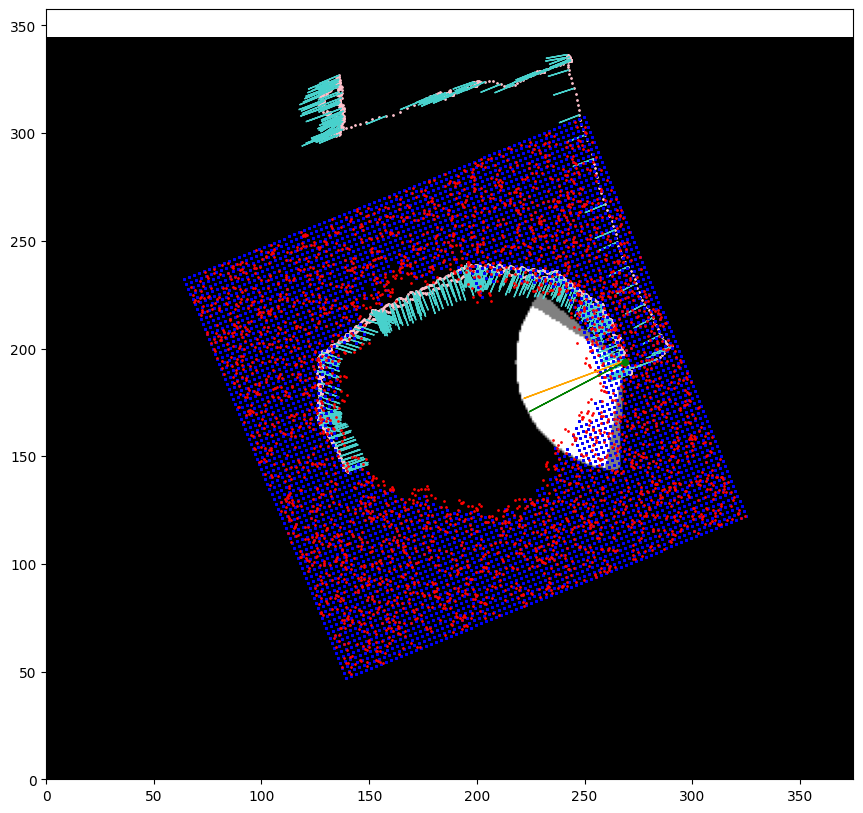

<Figure size 640x480 with 0 Axes>

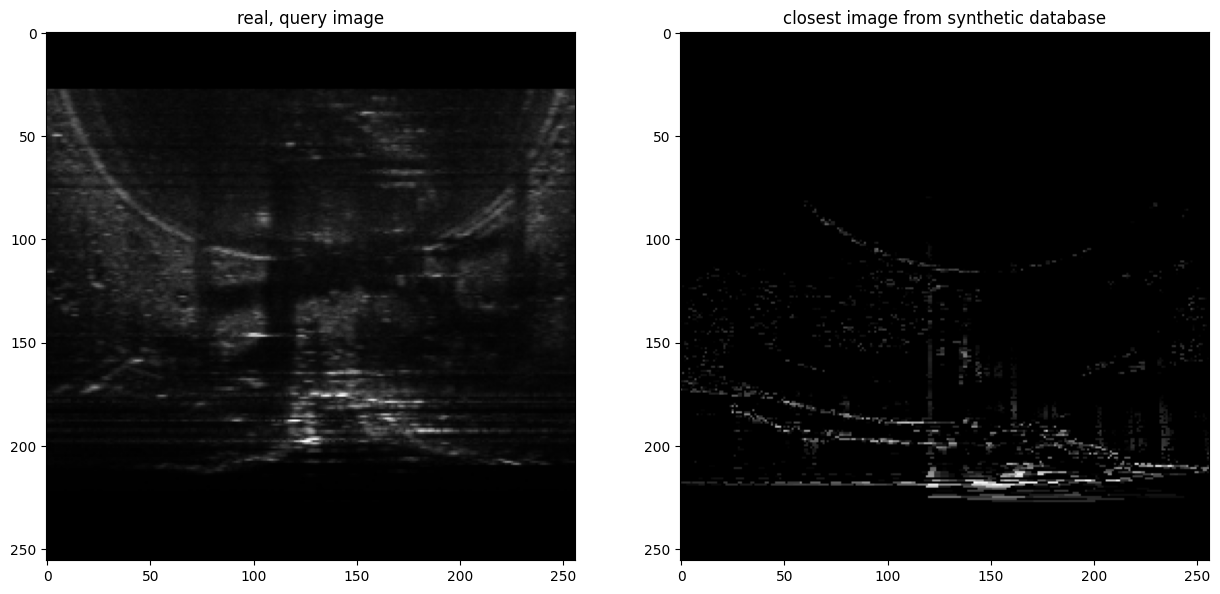

In [18]:
visualizer.localization(train_data, val_data, real_data)

In [19]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 24005
Validation: 3253
Test: 3271


In [20]:
val_data = visualizer.check_gt(train_data, val_data)

In [21]:
test_data = visualizer.check_gt(train_data, test_data)

In [22]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 24005
Validation: 3251
Test: 3267


In [23]:
batch = 16
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [24]:
model_name = "U-Net"

In [25]:
net = UNet.Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [26]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

In [27]:
total_params = metrics.count_parameters(net)
print("Total parameters: ", total_params)

Total parameters:  31037317


## Training Pipeline

### Train epochs

In [28]:
trainer = Trainer(writer, train_data, train_dataloader, val_data, net, optimizer, scheduler, drop, recocriterion, locacriterion)
num_epochs = 12

start_train = time.time()
best_model_path = trainer.train(num_epochs)
end_train = time.time()

training_time = end_train - start_train
print("Training time: ", training_time, "seconds")

epoch: 1


100%|███████████████████████████████████████| 1501/1501 [30:26<00:00,  1.22s/it]


train loss mean: 0.25957733400068
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [13:24<00:00, 29.85it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [01:48<00:00, 29.86it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [07:26<00:00,  7.28it/s]


average localization error: 12.2476 meters
average orientation error : 88.1706 degrees
epoch: 2


  6%|██▎                                      | 86/1501 [01:43<28:25,  1.21s/it]


KeyboardInterrupt: 

In [51]:
inference_time_per_image = metrics.inference_time(net, train_dataloader)
print("Inference time per image: ", inference_time_per_image, "seconds")

Inference time per image:  0.019927382469177246 seconds


In [32]:
metrics.get_descriptors(train_data, val_data, net)

100%|█████████████████████████████████████| 24005/24005 [12:20<00:00, 32.40it/s]


computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [12:25<00:00, 32.20it/s]
/home/firp/Desktop/Notebook_bsd/metrics.py:94: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [01:40<00:00, 32.36it/s]


descriptors computed!
torch.Size([3251]) torch.Size([3251, 5])
avg_metric_e     : tensor(117.9993)
avg_metric_e_top5: tensor(54.8439)


## Visualize Training results on Test data

### Load the checkpoint model

In [34]:
checkpoint_path = best_model_path
print("Best model path: ", best_model_path)
net = U.Model()
train_funct.load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [35]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [12:23<00:00, 32.30it/s]

descriptors computed!


### Visualize query results: sonar images

In [36]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 64, 256, 256]) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(7.6577, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 128, 128]) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(5.5305, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 256, 64, 64]) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(5.6060, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 512, 32, 32]) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(3.7894, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(7.6577, device='cuda:0', grad_fn=<MaxBackward1>)


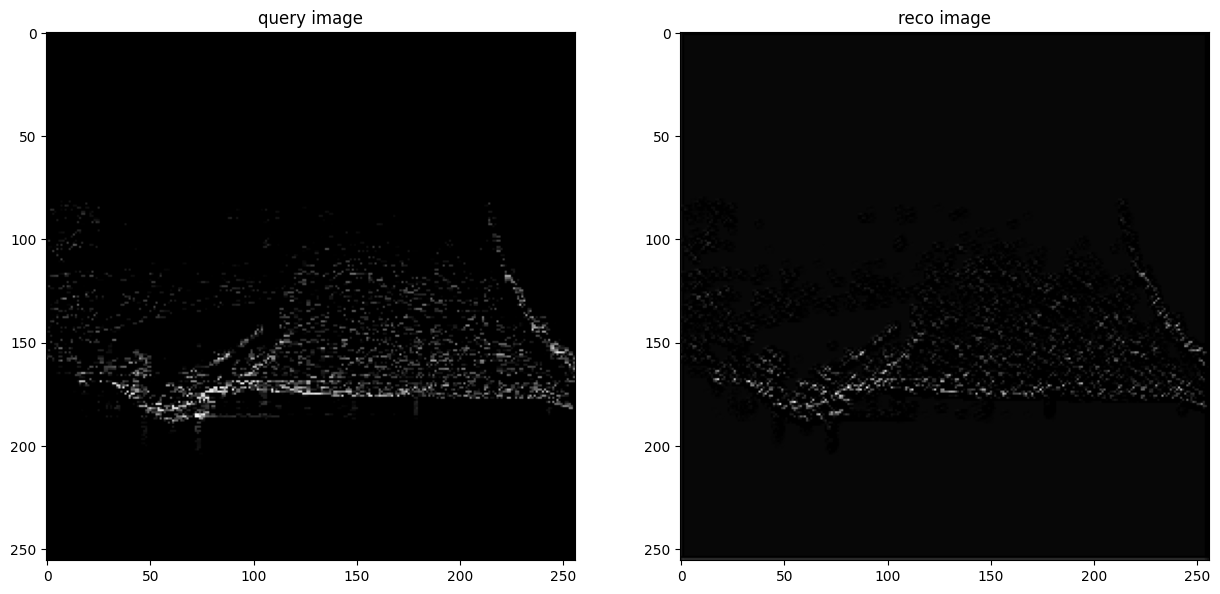

In [37]:
visualizer.analyze_feature_robustness(train_data, net)

iou: 0.0
localization error: 17.0459 meters
orientation error : 116.3681 degrees


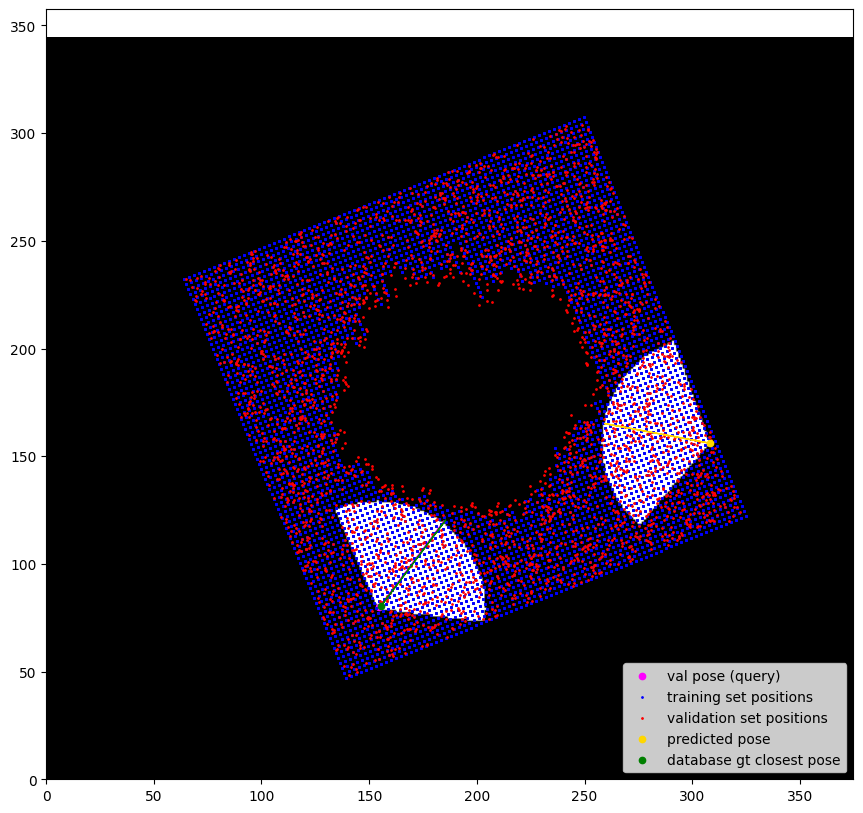

<Figure size 640x480 with 0 Axes>

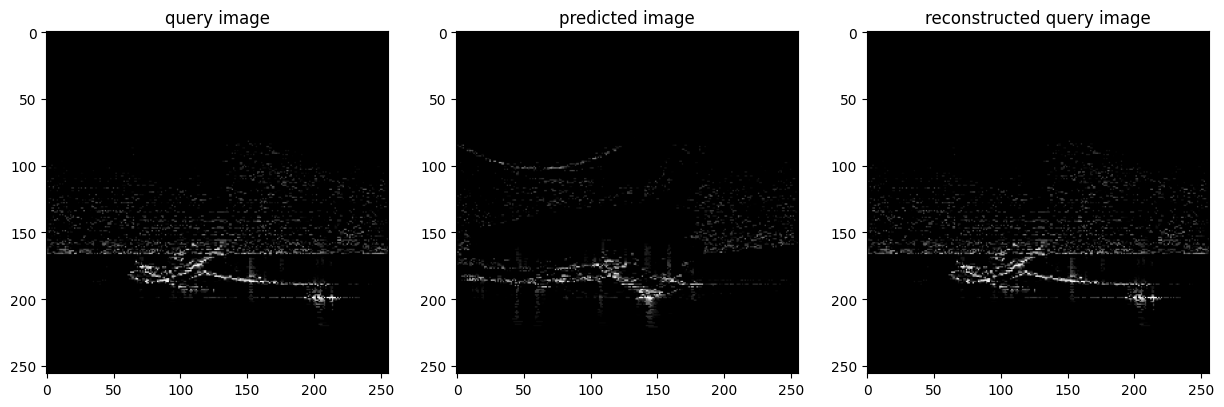

In [38]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [39]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_t = avg_loca_error
aoe_t = avg_orie_error

100%|███████████████████████████████████████| 3267/3267 [07:34<00:00,  7.20it/s]

average localization error: 12.1550 meters
average orientation error : 87.9527 degrees


In [40]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [41]:
loca_errors.argmax()

np.int64(1485)

In [42]:
le = loca_errors[loca_errors<10]
oe = orie_errors[orie_errors<10]
print(le.mean())
print(oe.mean())

5.2510643
5.2644625


## Process real images

query_idx: 281
237.44995 232.1399 0.4858141 -152.1649
iou: 0.0
localization error Upper:  14.714717 meters


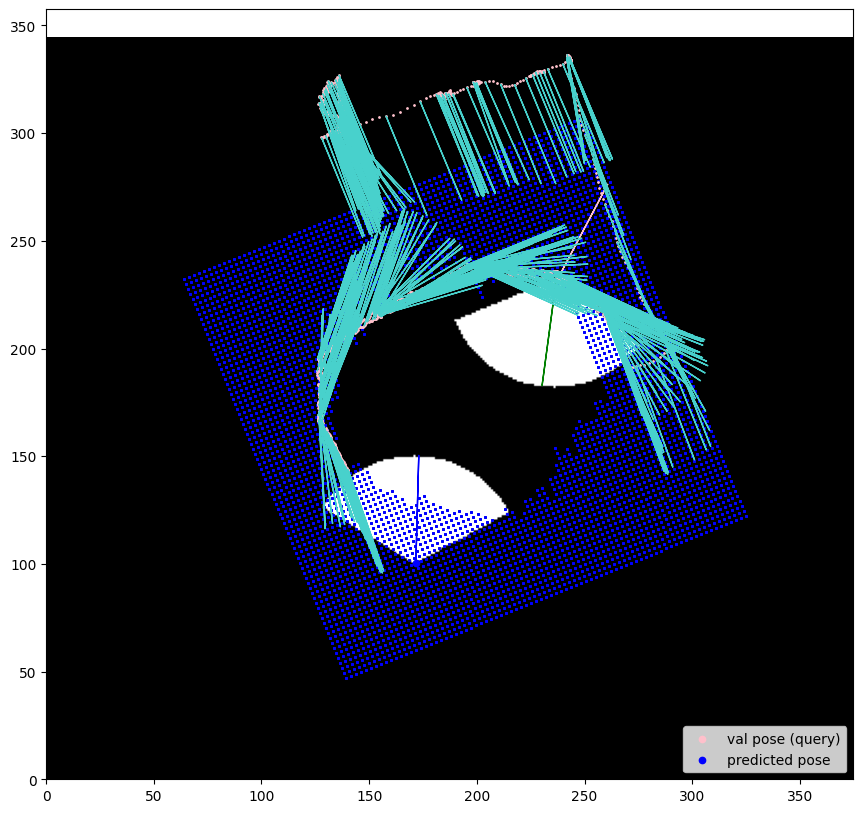

<Figure size 640x480 with 0 Axes>

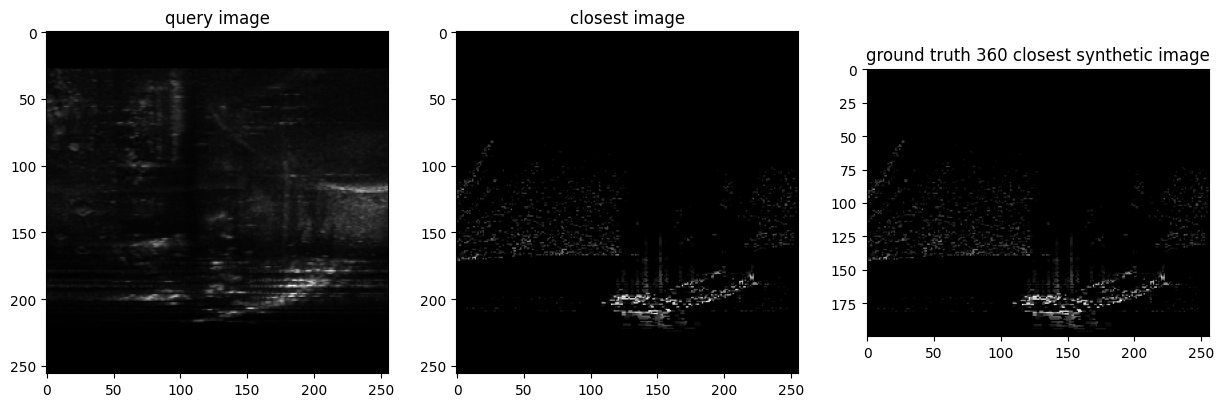

In [43]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
visualizer.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [44]:
real_data_train = load_only_real_datasets.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real_datasets.SonarDescriptorOnlyRealDataset(real_data_train)

In [45]:
real_data_train.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████████| 710/710 [00:22<00:00, 31.04it/s]

descriptors computed!


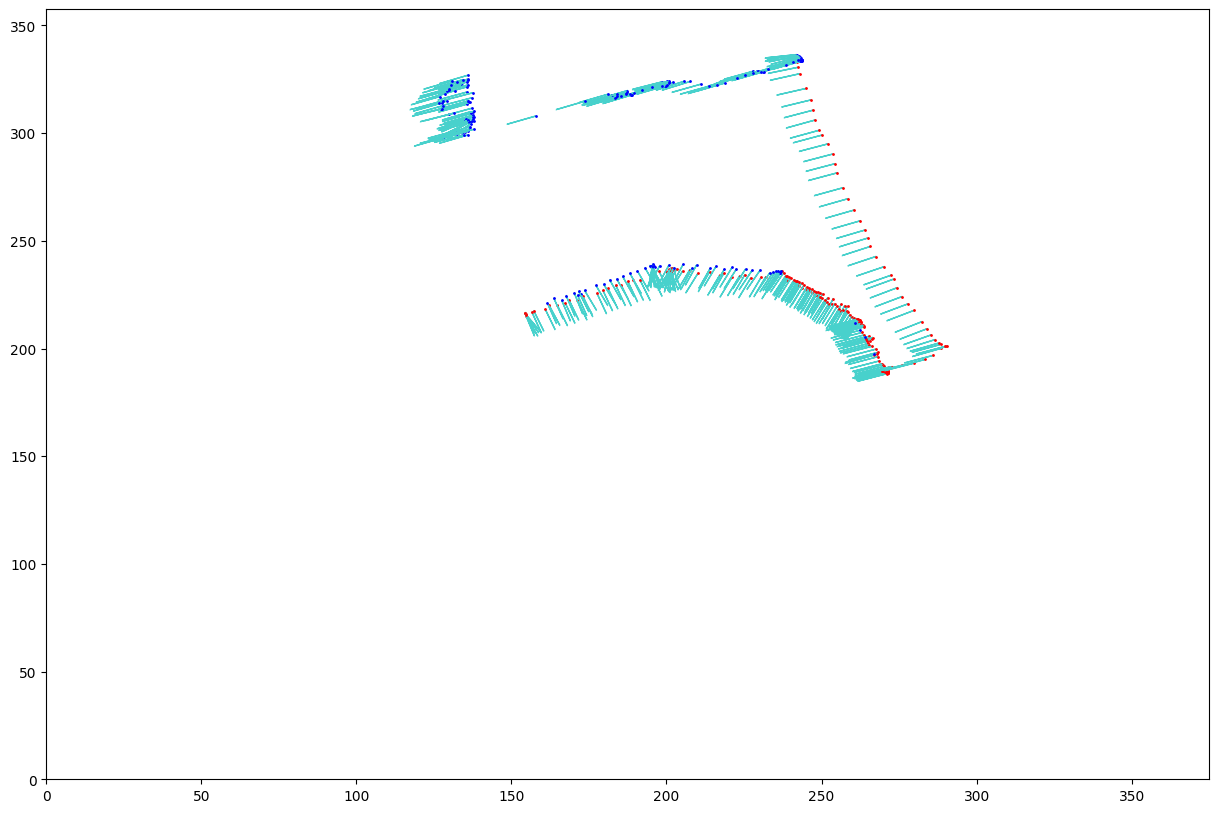

In [46]:
visualizer.visualize_real(train_data, real_data)

iou: 0.0
localization error: 9.7443 meters
orientation error : 87.7886 degrees


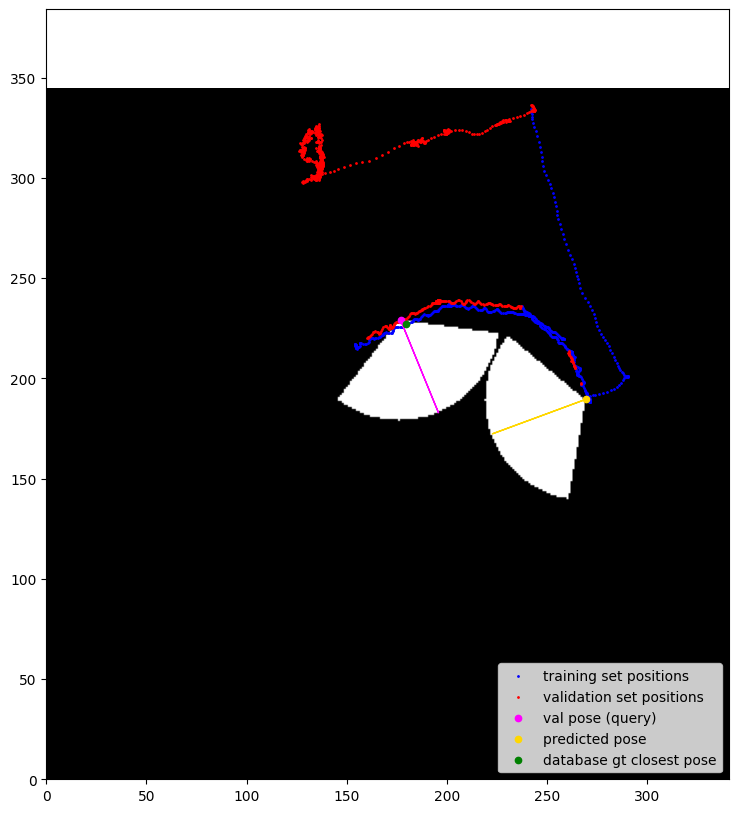

<Figure size 640x480 with 0 Axes>

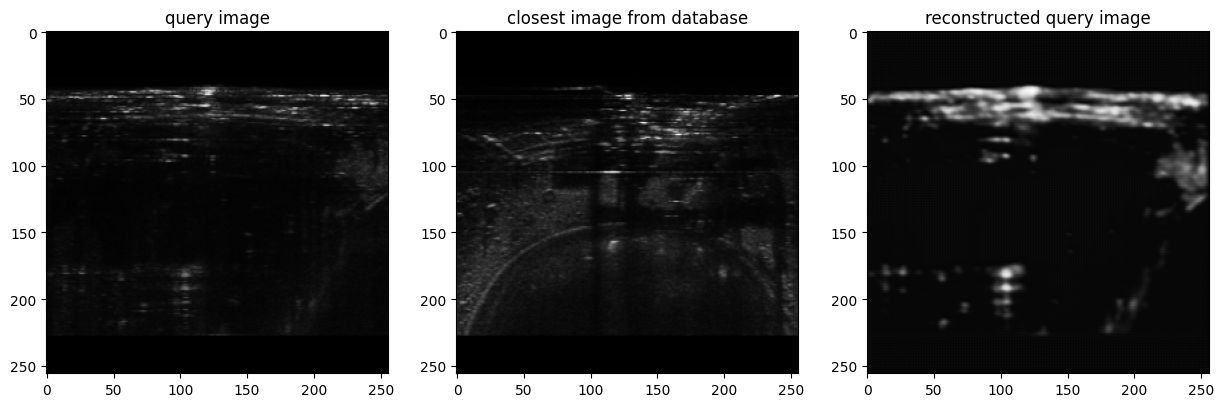

In [47]:
query_idx = random.randint(700, len(real_data_valid))
loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [48]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_r = avg_loca_error
aoe_r = avg_orie_error

100%|█████████████████████████████████████████| 785/785 [00:33<00:00, 23.79it/s]

average localization error: 7.4700 meters
average orientation error : 40.1774 degrees


In [49]:
avg_orie_error.min()

np.float32(40.177414)

## Results

In [50]:
file_path = "results.csv"
metrics.save_results(model_name, total_params, training_time, inference_time_per_image, ale_t, aoe_t, ale_r, aoe_r, file_path)

print(f"Model name: {model_name}")
print(f"Total parameters: {total_params}")
print(f"Training time: {training_time:6.4f} seconds")
print(f"Inference time per image: {inference_time_per_image:6.4f} seconds")
print(f"Average localization error in Test: {ale_t:6.4f} meters")
print(f"Average orientation error in Test: {aoe_t:6.4f} degrees")
print(f"Average localization error in Real: {ale_r:6.4f} meters")
print(f"Average orientation error in Real: {aoe_r:6.4f} degrees")

NameError: name 'training_time' is not defined